## 4GMM - HPC - 2021-22 
### F. Couderc, L. Giraud

***

# MPI parallelization and optimization of the Google PageRank problem

We will focus in this work on the optimization and parallelization of the Google PageRank problem, which consists in searching for the eigenvector associated with the highest eigenvalue of 1 of the stochastic matrix linking the web pages together.

## Introduction
PageRank (PR) is an algorithm used by Google Search to rank web pages in their search engine results. It is not the only algorithm used by Google to order search results, but it is the first algorithm that was used by the company, and it is the best known. The fundamental idea put forth by PageRank’s creators, Sergey Brin and Lawrence Page, is this: the importance of a page is judged by the number of pages linking to it as well as their importance.

We will assign to each web page $P$ a measure of its importance $I(P)$,
called the page's PageRank. Suppose that page $P_{i}$ has $\ell_{i}$
links. If one of those links is to page $P_{j}$, then $P_{i}$ will
pass on $1/\ell_{i}$ of its importance to $P_{j}$. The importance
ranking of $P_{j}$ is then the sum of all the contributions made
by pages linking to it. That is, if we denote the set of pages linking
to $P_{j}$ by $B_{j}$,
$$
I(P_{j})={\displaystyle \sum_{P_{i}\in B_{j}}\frac{I(P_{i})}{\ell_{i}},}
$$
and we first need to know the importance of all the pages linking
to it. However, we may recast the problem into one that is more mathematically
familiar. Let's first create a matrix, called the hyperlink matrix,
${\bf H}=[H_{ij}]$ in which the entry in the ith row and jth column
is

$$
H_{ij}=\left\{ \begin{array}{ll}
1/{\ell}_{i} & \text{if}\;P_{i}\in B_{j}\\
0 & \text{otherwise}
\end{array}\right..
$$

![network](img/network.png)

Then, the corresponding matrix to the figure above is

$$
\mathbf{H}=\left(\begin{array}{cccccccc}
0 & 1/2 & 1/2 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
0 & 1/2 & 0 & 0 & 1/2 & 0 & 0 & 0\\
0 & 1/3 & 0 & 0 & 1/3 & 1/3 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1/3 & 1/3 & 1/3\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\
1/3 & 0 & 0 & 0 & 1/3 & 0 & 0 & 1/3\\
0 & 0 & 0 & 0 & 0 & 1/2 & 1/2 & 0
\end{array}\right)
$$

Notice that $\mathbf{H}$ has some special properties. First, its
entries are all nonnegative. Also, the sum of the entries in a row
is one unless the page corresponding to that row has no links. We
will also form a vector $I=[I(P_{i})]$ whose components are PageRanks.
The condition above defining the PageRank may be expressed as

$$
\pi^{T}=\pi^{T}{\bf H}
$$

In other words, the vector $\pi$ is an eigenvector of the matrix
$\mathbf{H}^{T}$ with eigenvalue 1. We also call this a *stationary
vector* of $\mathbf{H}$. The solution of the problem
is

$$
\pi=\left(\begin{array}{cccccccc}
%0,0600 & 0,0675 & 0,0300 & 0,0675 & 0,0975 & 0,2025 & 0,1800 & 0,2950\end{array}\right)^{T}
0.14  & 0.158 & 0.07  & 0.158 & 0.228 & 0.473 & 0.42  & 0.689\end{array}\right)^{T}
$$

In [1]:
import functools
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as ssp
from mpi4py import MPI

# Some options
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
np.set_printoptions(precision=3)

# Matrix to be tested
def init_H_ex():
    H = ssp.lil_matrix((8, 8), dtype=np.float64)
    H[0, 1] = 1.0 / 2.0
    H[0, 2] = 1.0 / 2.0
    H[1, 3] = 1.0
    H[2, 1] = 1.0 / 2.0
    H[2, 4] = 1.0 / 2.0
    H[3, 1] = 1.0 / 3.0
    H[3, 4] = 1.0 / 3.0
    H[3, 5] = 1.0 / 3.0
    H[4, 5] = 1.0 / 3.0
    H[4, 6] = 1.0 / 3.0
    H[4, 7] = 1.0 / 3.0
    H[5, 7] = 1.0
    H[6, 0] = 1.0 / 3.0
    H[6, 4] = 1.0 / 3.0
    H[6, 7] = 1.0 / 3.0
    H[7, 5] = 1.0 / 2.0
    H[7, 6] = 1.0 / 2.0
    return H.tocsr()


H = init_H_ex()
print(H.todense())

# To plot the result of the Google Page Rank problem
def plt_sol(A, v):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar(np.arange(A.shape[0], dtype=int), np.abs(v.real))
    ax.set_xlabel("Eigenvector entries")
    ax.set_ylabel("Scores")
    ax.set_title("Google Page Rank problem")
    plt.grid()
    plt.show()


[[0.    0.5   0.5   0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.5   0.    0.    0.5   0.    0.    0.   ]
 [0.    0.333 0.    0.    0.333 0.333 0.    0.   ]
 [0.    0.    0.    0.    0.    0.333 0.333 0.333]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.333 0.    0.    0.    0.333 0.    0.    0.333]
 [0.    0.    0.    0.    0.    0.5   0.5   0.   ]]


## Exercice 1
  1. Compute the eigenvalues of $H^T$, what is the largest one ? Can you prove it using classical linear algebra arguments ?
  2. Compute the eigenvector associated with the largest eigenvalue. How can you exploit this vector to define the page ranking: what is most meaningful page for the search ?

Largest eigenvalue  0.9999999999999992
Associated eigenvector  [0.14  0.158 0.07  0.158 0.228 0.473 0.42  0.689]


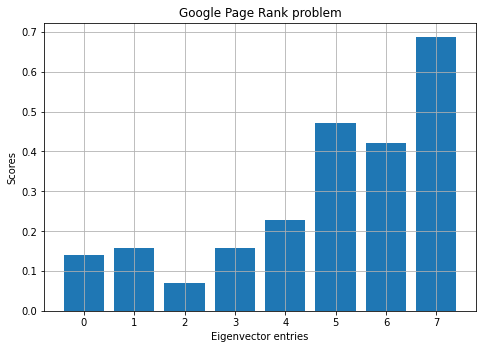

In [2]:
from scipy.sparse.linalg import eigs

vals, vecs = eigs(H.T)
val, vec = vals[0].real, vecs[:, 0].real

print("Largest eigenvalue ", val)
print("Associated eigenvector ", vec)

plt_sol(H, vec)


On can find the solution of this problem using the power iteration
method defined below
1. Set  $u=random$ and  $u=u/\Vert u\Vert$
2. WHILE{$\left\Vert u-v\right\Vert >\epsilon$} 
3. $\quad$ Compute $v=\mathbf{G}^{T}u$
3. $\quad$ Define $\lambda=u^{T}v$ and $u=v/\Vert v\Vert$
4. ENDWHILE

## Exercice 2
 - Complete the power iteration algorithm in the next cell
   1. validate your implementation first on a diagonal matrix
   1. check that you get the "same" eigenpairs as the eigs function



### First define a few functions

In [3]:
# Define few functions that will be usefull for the power method implementation


def norm1(u):
    # compute the 1-norm of the input vector u
    return np.sum(np.abs(u))


def norm2(u):
    # compute the 2-norm of the input vector u
    return np.sqrt(u.dot(u))


def dot_product(u, v):
    # compute the scalar product of the two input vectors u and v
    return u.dot(v)


### Next define the power iteration function which first parameter is the function computing the matrix-vector product

number of iterations =  60
residual = 8.17e-09
eigenvalue = 4.000000e+00
eigenvector = [8.306e-37 1.390e-18 2.452e-08 1.000e+00]
highest pagerank = 3
Computational time = 0.003381967544555664
number of iterations = 115
residual = 9.04e-09
eigenvalue = 1.000000e+00
eigenvector = [0.14  0.158 0.07  0.158 0.228 0.473 0.42  0.689]
highest pagerank = 7
Computational time = 0.004458904266357422


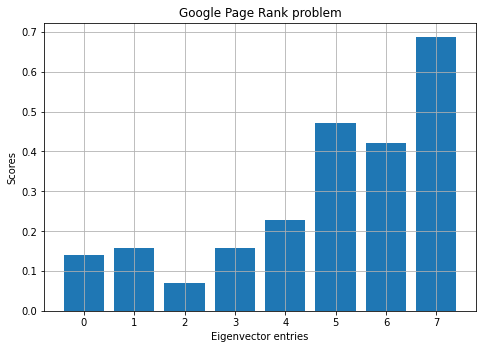

In [4]:
# Power Iteration Method
def power_iteration(matvec, G, u, v, tol=1e-8, itmax=200):
    t = time.time()
    it = 0
    diff_norm = 2 * tol
    while it < itmax and diff_norm > tol:
        v = matvec(G, u)
        l = dot_product(u, v)
        v = (1 / norm2(v)) * v
        diff_norm = norm2(u - v)
        u = v
        it += 1
    print("number of iterations = %3d" % it)
    print("residual = %7.2e" % diff_norm)
    print("eigenvalue = %11.6e" % l)
    print(f"eigenvector = {u}")
    print(f"highest pagerank = {np.argmax(u)}")
    print(f"Computational time = {time.time() - t}")
    return l, v


# For testing purpose define a digonal matrix so that its eigenvalues are known
A = np.diag([1, 2, 3, 4])

# Initialize the variables
n = A.shape[0]
u = np.random.uniform(0, 1, n)
v = np.zeros(n)

# Define a function that perform the matrix vector product (will be used as input parameter)
def matvec(A, x):
    return A @ x


# Call the power iteration method
l, u = power_iteration(matvec, A, u, v)

# Initialize the variables
n = H.shape[0]
u = np.random.uniform(0, 1, n)
v = np.zeros(n)

l, u = power_iteration(matvec, H.T, u, v)
np.testing.assert_almost_equal(l, 1)
np.testing.assert_almost_equal(u, vec)

# Display the result in a bar plot
plt_sol(H, u)


In general there is no guarantee that the algorithm will work.
First, it is very likely that there are pages that are not linked
to any other page, what it is called **dangling** nodes. 
Such a node gives rise to zero row in the hyperling matrix that is not longer stochastic.
It is corrected introducing a *random surfer* for these pages, linking
them to all other pages. The same phenomenon happens for a cluster
of pages, the original matrix is then balanced with a scaling parameter
$\alpha$ with a global *random surfer matrix* to finally obtain
the so-called Google matrix

$$
\mathbf{G}=\alpha(\mathbf{H}+1/n\mathbf{d}\mathbf{e}^{T})+(1\text{−}\alpha)1/n\mathbf{e}\mathbf{e}^{T}
$$

where,
 - $\mathbf{H}$ is a very sparse hyperlink matrix.
 - $\alpha$ is a scaling parameter between 0 and 1 (generally set at
the “magic” value of $0.85$).
 - $\mathbf{a}^{T}$ is the binary dangling node row vector ($a_{i}$
= 1 if page $i$ is a dangling node and 0 otherwise).
 - $\mathbf{e}^{T}$ is the row vector of all entries 1.
 
--- 

## Exercice 3
 1. Show the matrix $\mathbf{G}$ is stochastic.
 1. Compute the Google matrix in dense format and compute its page ranking.

number of iterations =  59
residual = 8.02e-09
eigenvalue = 1.000000e+00
eigenvector = [0.159 0.233 0.115 0.245 0.277 0.464 0.394 0.632]
highest pagerank = 7
Computational time = 0.001528024673461914


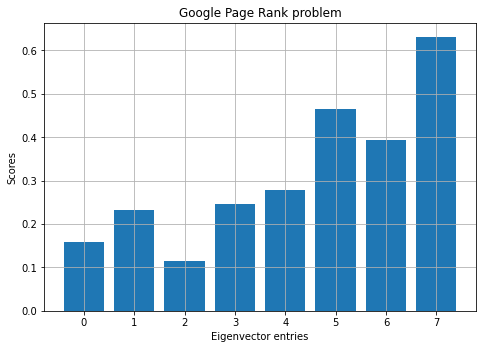

In [5]:
# Define a function that return the vector index of the dangling nodes
def dangling_nodes(H):
    return np.where(np.sum(H, axis=1).A1 == 0.0, 1.0, 0.0)


# Define the Google matrix in dense format
def google_matrix_dense(M, alpha=0.85):
    d = dangling_nodes(M)
    n = np.shape(M)[0]
    e = np.ones(n)
    return alpha * M.A + alpha / n * np.outer(d, e) + (1 - alpha) / n * np.outer(e, e)


# Compute it largest eigenvalue and associated eigenvector
Gdense = google_matrix_dense(H)

u = np.random.uniform(0, 1, n)
v = np.zeros(n)

l, u = power_iteration(matvec, Gdense.T, u, v)
np.testing.assert_almost_equal(l, 1)

# Display the result in a bar plot
plt_sol(Gdense, u)


## Exercice 4

- A program **norms_mpi.py** is provided, finish to write the MPI routines to perform the distributed computations of 1-2 norms as the dot product.
- A program **matvec_mpi** is provided, finish to write the MPI routine to perform the distributed matrix/vector product.
- With the use of the MPI parallelized computations of norms and matrix/vector product, write a program from provided **pagerank_dense.py** to parallelize the power iteration method.

These matrices provided in numpy npz binary format will be used to test the final program:

In [6]:
def init_H(p=1):
    if p == 1:
        return ssp.load_npz("random10.npz")
    elif p == 2:
        return ssp.load_npz("random100.npz")
    elif p == 3:
        return ssp.load_npz("random1000.npz")
    elif p == 4:
        return ssp.load_npz("random10000.npz")
    else:
        return ssp.load_npz("ucam2006.npz")


## Exercice 5


It is requested to use the structure of the $\mathbf{G}$ matrix to reduce the resolution to a sparse problem, greatly reducing the number of floating point operations required. Rewrite the given power iteration method by introducing a sparse matrix/vector product of the matrix $\mathbf{H}$ with the vector $u$ and some additional dot product by exploiting the nature of the matrices $\mathbf{a}\mathbf{e}^{T}$ and $\mathbf{e}\mathbf{e}^{T}$ of rank 1.

number of iterations =  57
residual = 9.36e-09
eigenvalue = 1.000000e+00
eigenvector = [0.159 0.233 0.115 0.245 0.277 0.464 0.394 0.632]
highest pagerank = 7
Computational time = 0.004273891448974609


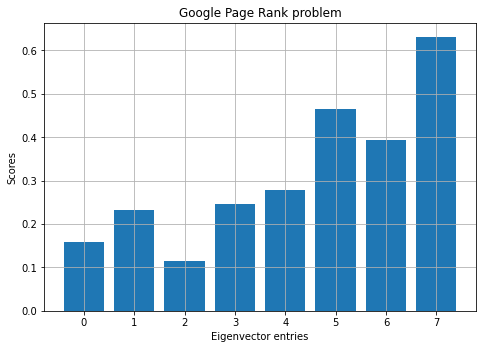

In [7]:
# Define a function that perform a matrix vector product using the Google matrix using sparsity
def matvec_sparse(M, x, d, alpha=0.85):
    m, n = np.shape(M)
    e = np.ones(m)
    return (
        alpha * M.dot(x)
        + alpha / n * d.dot(x)
        + (1 - alpha) / n * e.dot(x)
    )


u = np.random.uniform(0, 1, n)
v = np.zeros(n)

d = dangling_nodes(H)

l, u = power_iteration(functools.partial(matvec_sparse, d=d), H.T, u, v)
np.testing.assert_almost_equal(l, 1)

# Display the result in a bar plot
plt_sol(Gdense, u)


## Exercice 6

the use of the MPI parallelized computations of norms and matrix/vector product, write a program from provided **pagerank_sparse.py** to parallelize the power iteration method.

## Exercice 7
Let consider the matrix
$$\mathbf{B^{T}}=\left(\begin{array}{lll|lll|lll}
 & 1/2 & 1/3 & 1/3 & 1/3 & 1/3 & 1/3 & 1/3 & 1/2\\
1/8 &  & 1/3 &  &  & \\
1/8 & 1/2 &  & 1/3 &  & \\
\hline 1/8 &  & 1/3 &  & 1/3 & \\
1/8 &  &  & 1/3 &  & 1/3\\
1/8 &  &  &  & 1/3 &  & 1/3\\
\hline 1/8 &  &  &  &  & 1/3 &  & 1/3\\
1/8 &  &  &  &  &  & 1/3 &  & 1/2\\
1/8 &  &  &  &  &  &  & 1/3
\end{array}\right).
$$
 - Is the matrix stochastic ?
 - What is the graph associated with it ? Does it have dangling nodes ?
 - What is the node with the highest rank ?
 - Compute the dominant eigenvector to assess your guess.

[[0.    0.5   0.333 0.333 0.333 0.333 0.333 0.333 0.5  ]
 [0.125 0.    0.333 0.    0.    0.    0.    0.    0.   ]
 [0.125 0.5   0.    0.333 0.    0.    0.    0.    0.   ]
 [0.125 0.    0.333 0.    0.333 0.    0.    0.    0.   ]
 [0.125 0.    0.    0.333 0.    0.333 0.    0.    0.   ]
 [0.125 0.    0.    0.    0.333 0.    0.333 0.    0.   ]
 [0.125 0.    0.    0.    0.    0.333 0.    0.333 0.   ]
 [0.125 0.    0.    0.    0.    0.    0.333 0.    0.5  ]
 [0.125 0.    0.    0.    0.    0.    0.    0.333 0.   ]]
number of iterations =  41
residual = 7.24e-09
eigenvalue = 1.000000e+00
eigenvector = [0.713 0.178 0.267 0.267 0.267 0.267 0.267 0.267 0.178]
highest pagerank = 0
Computational time = 0.0020852088928222656


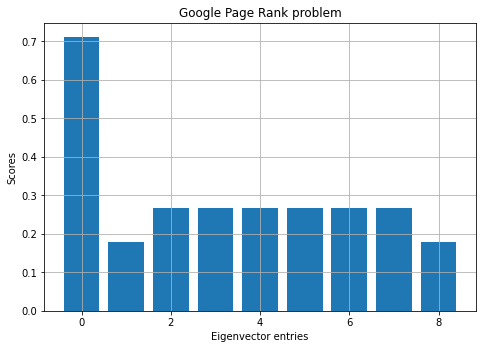

In [8]:
def init_B(n):
    # Setup the matrix define above for any size n
    B = ssp.lil_matrix((n, n), dtype=np.float64)
    B.setdiag(np.ones(n - 1), -1)
    B[1:, 0] = 1.0
    B = B + B.T
    B = B * ssp.diags(1 / B.sum(axis=0).A.ravel())
    return B


n = 9
B = init_B(n)

print(B.todense())

u = np.random.uniform(0, 1, n)
v = np.zeros(n)

l, u = power_iteration(matvec, B, u, v)
np.testing.assert_almost_equal(l, 1)

plt_sol(B, u)


## Exercice 8

- Rewrite a parallelized computation of a matrix/vector product exploiting the structure the matrix B in order to optimize the necessary MPI exchanges by drastically reducing their size.

Find here a routine to generate the matrix B distributed along rows:

In [9]:
def init_B_mpi(n, comm=MPI.COMM_WORLD):

    size = comm.size
    rank = comm.rank

    Bglob = ssp.lil_matrix((n * size, n * size), dtype=np.float64)
    Bglob.setdiag(np.ones(n * size - 1), -1)
    Bglob[1:, 0] = 1.0
    Bglob = Bglob + Bglob.T
    Bglob = Bglob * ssp.diags(1 / Bglob.sum(axis=0).B.ravel())

    if rank == 0:
        B = ssp.lil_matrix((n, n * size), dtype=np.float64)
        B = Bglob[0:n, :]
        u = np.zeros(n * size)
        start = 0
        end = n
    elif rank == size - 1:
        B = ssp.lil_matrix((n, n + 2), dtype=np.float64)
        B[:, 0] = Bglob[n * rank : n * rank + n, 0]
        B[:, 1 : n + 2] = Bglob[n * rank : n * rank + n, n * rank - 1 : n * rank + n]
        u = np.zeros(n + 2)
        start = 2
        end = n + 2
    else:
        B = ssp.lil_matrix((n, n + 3), dtype=np.float64)
        B[:, 0] = Bglob[n * rank : n * rank + n, 0]
        B[:, 1 : n + 3] = Bglob[
            n * rank : n * rank + n, n * rank - 1 : n * rank + n + 1
        ]
        u = np.zeros(n + 3)
        start = 2
        end = n + 2

    return B, u, start, end
